<a href="https://colab.research.google.com/github/itonui/Machine-Learning/blob/main/portfolio_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set Up SQLite Database

In [1]:
import sqlite3

# Connect to an SQLite database in Colab runtime
conn = sqlite3.connect("portfolio.db")
cursor = conn.cursor()

# Create table for financial assets
cursor.execute('''
CREATE TABLE IF NOT EXISTS financial_assets (
    asset_id INTEGER PRIMARY KEY AUTOINCREMENT,
    asset_name TEXT,
    asset_symbol TEXT,
    asset_type TEXT,
    purchase_price REAL,
    current_price REAL,
    purchase_date TEXT,
    quantity INTEGER
)
''')

conn.commit()
conn.close()
print("Database setup complete!")


Database setup complete!


 Insert Sample Data

In [2]:
def insert_sample_data():
    assets = [
        ("Apple", "AAPL", "Stock", 150.00, 0, "2023-06-01", 10),
        ("Tesla", "TSLA", "Stock", 200.00, 0, "2023-07-15", 5),
        ("Amazon", "AMZN", "Stock", 110.00, 0, "2023-08-20", 8),
    ]

    conn = sqlite3.connect("portfolio.db")
    cursor = conn.cursor()

    cursor.executemany('''
    INSERT INTO financial_assets (asset_name, asset_symbol, asset_type, purchase_price, current_price, purchase_date, quantity)
    VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', assets)

    conn.commit()
    conn.close()
    print("Sample data inserted!")

insert_sample_data()


Sample data inserted!


Install yfinance and Fetch Stock Prices

In [3]:
!pip install yfinance


In [4]:
import yfinance as yf

def update_prices():
    conn = sqlite3.connect("portfolio.db")
    cursor = conn.cursor()

    cursor.execute("SELECT asset_symbol FROM financial_assets")
    symbols = [row[0] for row in cursor.fetchall()]

    for symbol in symbols:
        stock = yf.Ticker(symbol)
        current_price = stock.history(period="1d")["Close"].iloc[-1]

        cursor.execute("UPDATE financial_assets SET current_price = ? WHERE asset_symbol = ?", (current_price, symbol))

    conn.commit()
    conn.close()
    print("Stock prices updated!")

update_prices()


Stock prices updated!


Portfolio Performance Analysis

In [5]:
import pandas as pd

def analyze_portfolio():
    conn = sqlite3.connect("portfolio.db")
    df = pd.read_sql_query("SELECT * FROM financial_assets", conn)
    conn.close()

    # Calculate total investment and current value
    df["total_investment"] = df["purchase_price"] * df["quantity"]
    df["current_value"] = df["current_price"] * df["quantity"]
    df["profit_loss"] = df["current_value"] - df["total_investment"]
    df["return_%"] = (df["profit_loss"] / df["total_investment"]) * 100

    # Portfolio summary
    total_investment = df["total_investment"].sum()
    total_value = df["current_value"].sum()
    overall_return = ((total_value - total_investment) / total_investment) * 100

    print(df[["asset_name", "total_investment", "current_value", "profit_loss", "return_%"]])
    print(f"\nTotal Investment: ${total_investment:,.2f}")
    print(f"Current Portfolio Value: ${total_value:,.2f}")
    print(f"Overall Portfolio Return: {overall_return:.2f}%")

analyze_portfolio()


  asset_name  total_investment  current_value  profit_loss    return_%
0      Apple            1500.0    2332.200012   832.200012   55.480001
1      Tesla            1000.0    1871.600037   871.600037   87.160004
2     Amazon             880.0    1910.640015  1030.640015  117.118183

Total Investment: $3,380.00
Current Portfolio Value: $6,114.44
Overall Portfolio Return: 80.90%


Visualize Portfolio Performance

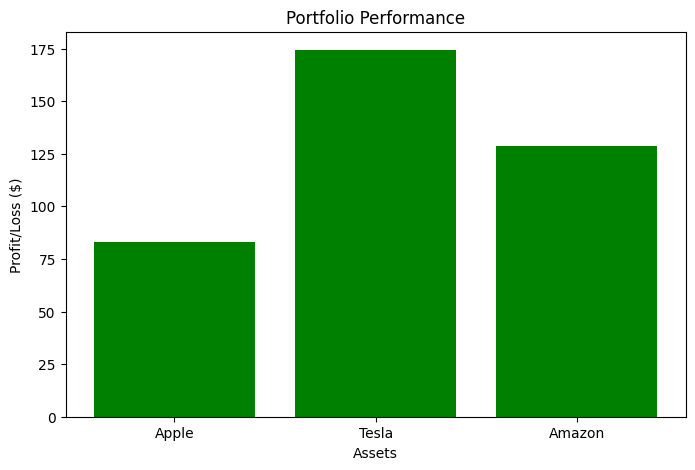

In [6]:
import matplotlib.pyplot as plt

def visualize_portfolio():
    conn = sqlite3.connect("portfolio.db")
    df = pd.read_sql_query("SELECT asset_name, purchase_price, current_price FROM financial_assets", conn)
    conn.close()

    df["profit_loss"] = df["current_price"] - df["purchase_price"]

    plt.figure(figsize=(8, 5))
    plt.bar(df["asset_name"], df["profit_loss"], color=["green" if x > 0 else "red" for x in df["profit_loss"]])
    plt.xlabel("Assets")
    plt.ylabel("Profit/Loss ($)")
    plt.title("Portfolio Performance")
    plt.show()

visualize_portfolio()


Automate Risk Analysis

In [7]:
import numpy as np

def calculate_risk():
    conn = sqlite3.connect("portfolio.db")
    df = pd.read_sql_query("SELECT asset_name, purchase_price, current_price FROM financial_assets", conn)
    conn.close()

    df["daily_return"] = (df["current_price"] - df["purchase_price"]) / df["purchase_price"]
    portfolio_risk = np.std(df["daily_return"]) * 100  # Convert to %

    print(f"Portfolio Volatility (Risk): {portfolio_risk:.2f}%")

calculate_risk()


Portfolio Volatility (Risk): 25.17%


Predict Stock Prices using LSTM (Long Short-Term Memory) Networks.

In [8]:
!pip install yfinance tensorflow scikit-learn


Fetch and Prepare Stock Data for LSTM

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fetch historical stock data
def get_stock_data(symbol, period="1y"):
    stock = yf.Ticker(symbol)
    df = stock.history(period=period)
    df = df[['Close']]  # We only need closing prices
    return df

# Example: Fetch Apple stock data
df = get_stock_data("AAPL")
print(df.head())

# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

# Prepare dataset for LSTM
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(df_scaled, seq_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


                                Close
Date                                 
2024-02-07 00:00:00-05:00  188.486603
2024-02-08 00:00:00-05:00  187.401932
2024-02-09 00:00:00-05:00  188.169128
2024-02-12 00:00:00-05:00  186.475266
2024-02-13 00:00:00-05:00  184.372864


Build & Train the LSTM Model

In [10]:
# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2440 - val_loss: 0.0664
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0301 - val_loss: 0.0412
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0127 - val_loss: 0.0095
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0069 - val_loss: 0.0142
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0062 - val_loss: 0.0102
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0046 - val_loss: 0.0106
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0048 - val_loss: 0.0102
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0047 - val_loss: 0.0106
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0040 - val_l

Predict Future Prices

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


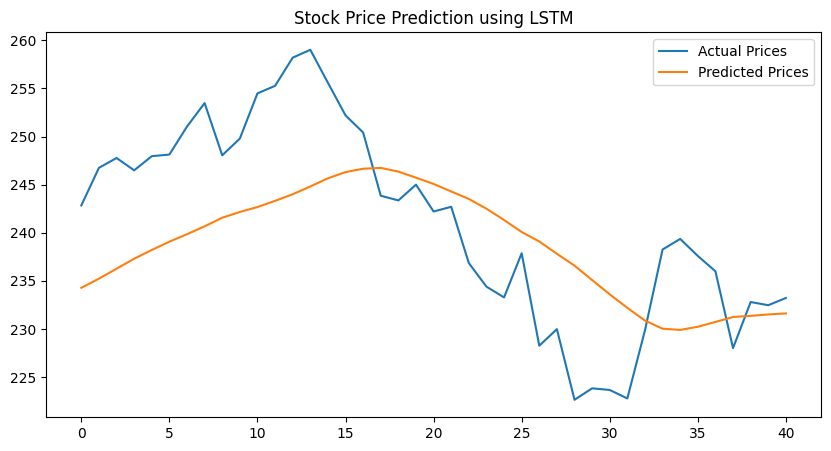

In [11]:
# Make predictions
predictions = model.predict(X_test)

# Transform predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.show()


Optimize Portfolio using Modern Portfolio Theory (MPT)

MPT helps allocate investments to maximize return while minimizing risk.

In [12]:
!pip install numpy pandas matplotlib scipy


 Portfolio Optimization Code

In [13]:
import numpy as np
from scipy.optimize import minimize

# Example: 3 assets (Apple, Tesla, Amazon)
assets = ["AAPL", "TSLA", "AMZN"]
df = pd.concat([get_stock_data(asset, period="1y")["Close"] for asset in assets], axis=1)
df.columns = assets

# Compute daily returns
returns = df.pct_change().dropna()

# Mean & covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define portfolio risk & return
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252  # Annualized return
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Annualized volatility
    return returns, risk

# Optimization: Maximize Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns, risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -((returns - risk_free_rate) / risk)

# Constraints & bounds
num_assets = len(assets)
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = np.array([1 / num_assets] * num_assets)

# Optimize
opt_results = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                       method="SLSQP", bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = opt_results.x
optimized_returns, optimized_risk = portfolio_performance(optimized_weights, mean_returns, cov_matrix)

# Print results
print("Optimized Portfolio Allocation:")
for asset, weight in zip(assets, optimized_weights):
    print(f"{asset}: {weight:.2%}")

print(f"Expected Return: {optimized_returns:.2%}")
print(f"Expected Risk: {optimized_risk:.2%}")


Optimized Portfolio Allocation:
AAPL: 23.92%
TSLA: 23.49%
AMZN: 52.60%
Expected Return: 46.66%
Expected Risk: 27.02%


Automate Alerts for Asset Performance

In [15]:
import smtplib

def send_email_alert(asset, current_price, threshold):
    sender_email = "your_email@gmail.com"
    receiver_email = "your_email@gmail.com"
    password = "your_app_password"  # Generate an app password for Gmail SMTP

    subject = f"ALERT: {asset} Price Drop"
    body = f"The price of {asset} has fallen to ${current_price}, below the threshold of ${threshold}."

    email_message = f"Subject: {subject}\n\n{body}"

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, email_message)
        server.quit()
        print(f"Alert sent for {asset}!")
    except Exception as e:
        print(f"Failed to send email: {e}")

# Example: Monitor stock price
def monitor_stocks():
    conn = sqlite3.connect("portfolio.db")
    cursor = conn.cursor()
    cursor.execute("SELECT asset_name, asset_symbol, current_price FROM financial_assets")
    stocks = cursor.fetchall()
    conn.close()

    price_thresholds = {"AAPL": 130, "TSLA": 180, "AMZN": 100}

    for stock in stocks:
        asset, symbol, price = stock
        if symbol in price_thresholds and price < price_thresholds[symbol]:
            send_email_alert(asset, price, price_thresholds[symbol])

monitor_stocks()
